# Aadhar Enrollment Data Analysis

## Phase 2: Analyzing New Enrolments
This notebook focuses on the **Enrollment Dataset**. Unlike biometric updates (which are for existing users), this dataset tracks **new people** entering the Aadhaar system.

### Key Objectives & Hypothesis:
1.  **Baal Aadhaar (0-5 Years)**: This should be the dominant category. The government pushes for "Blue Aadhaar" for newborns to reach 100% saturation. Trends here reflect birth rates and hospital-linkage efficiency.
2.  **School Age (5-17 Years)**: Enrolment here suggests "Leftover" children who missed early implementation. High numbers might indicate a "Catch-up drive" in schools.
3.  **Adult Saturation (18+ Years)**: This should ideally be **near zero**. High adult enrolment suggests either **Migration** or **Data Cleanup/Fraud**.

In [43]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Look in both the specific folder and current dir (for Colab compatibility)
POSSIBLE_FOLDERS = ['data', '.']
FILE_PATTERN = 'api_data_aadhar_enrolment*.csv'
DATE_COLUMN = 'date'
STATE_COLUMN = 'state'

def load_and_merge_data(folders, pattern):
    """Loads all CSV files matching the pattern from possible folders."""
    for folder in folders:
        search_path = os.path.join(folder, pattern)
        files = sorted(glob.glob(search_path))
        if files:
            print(f"Found {len(files)} files in folder: '{folder}'")
            df_list = [pd.read_csv(f) for f in files]
            merged_df = pd.concat(df_list, ignore_index=True)
            print(f"Successfully merged {len(merged_df)} rows.")
            return merged_df

    raise FileNotFoundError(f"No files found matching '{pattern}'. Did you upload them?")

# 1. Load Data
df = load_and_merge_data(POSSIBLE_FOLDERS, FILE_PATTERN)

Found 1 files in folder: '.'
Successfully merged 500000 rows.


In [44]:
# 2. Preprocess & Sort
if DATE_COLUMN in df.columns:
    print("Converting dates and sorting...")
    df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN], dayfirst=True)
    df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
    print("Data sorted by date.")
else:
    print(f"Warning: '{DATE_COLUMN}' column not found.")

Converting dates and sorting...
Data sorted by date.


In [45]:
# 3. Standardize State Names (Reusing the Robust Pipeline)

if STATE_COLUMN in df.columns:
    print("--- Cleaning State Names ---")

    initial_count = len(df)
    df = df.dropna(subset=[STATE_COLUMN])
    print(f"Dropped {initial_count - len(df)} rows with missing state.")

    df[STATE_COLUMN] = df[STATE_COLUMN].astype(str).str.title().str.strip()
    df[STATE_COLUMN] = df[STATE_COLUMN].str.replace(r'\s+', ' ', regex=True)
    df[STATE_COLUMN] = df[STATE_COLUMN].str.replace(' And ', ' & ', regex=False)

    # Typo Corrections
    corrections = {
        'W. Bengal': 'West Bengal', 'West Bangal': 'West Bengal', 'Westbengal': 'West Bengal',
        'Chhatisgarh': 'Chhattisgarh', 'Cg': 'Chhattisgarh',
        'J&K': 'Jammu & Kashmir', 'A & N Islands': 'Andaman & Nicobar Islands',
        'Tn': 'Tamil Nadu', 'Up': 'Uttar Pradesh', 'Del': 'Delhi'
    }
    df[STATE_COLUMN] = df[STATE_COLUMN].replace(corrections)

    print("States Cleaned. Unique States found:")
    print(sorted(df[STATE_COLUMN].unique()))

--- Cleaning State Names ---
Dropped 0 rows with missing state.
States Cleaned. Unique States found:
['100000', 'Andaman & Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra & Nagar Haveli', 'Dadra & Nagar Haveli & Daman & Diu', 'Daman & Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'The Dadra & Nagar Haveli & Daman & Diu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']


In [46]:
# 4. Export Cleaned Data
output_csv = 'aadhar_enrollment_cleaned.csv'
print(f"Saving cleaned dataset to {output_csv}...")
df.to_csv(output_csv, index=False)
print("Done.")

Saving cleaned dataset to aadhar_enrollment_cleaned.csv...
Done.


# 5. Detailed Analysis: The "Baal Aadhaar" Story

Here we execute the full analytics pipeline: Uni-variate (Totals), Bi-variate (Comparisons), and Tri-variate (Regional Trends).

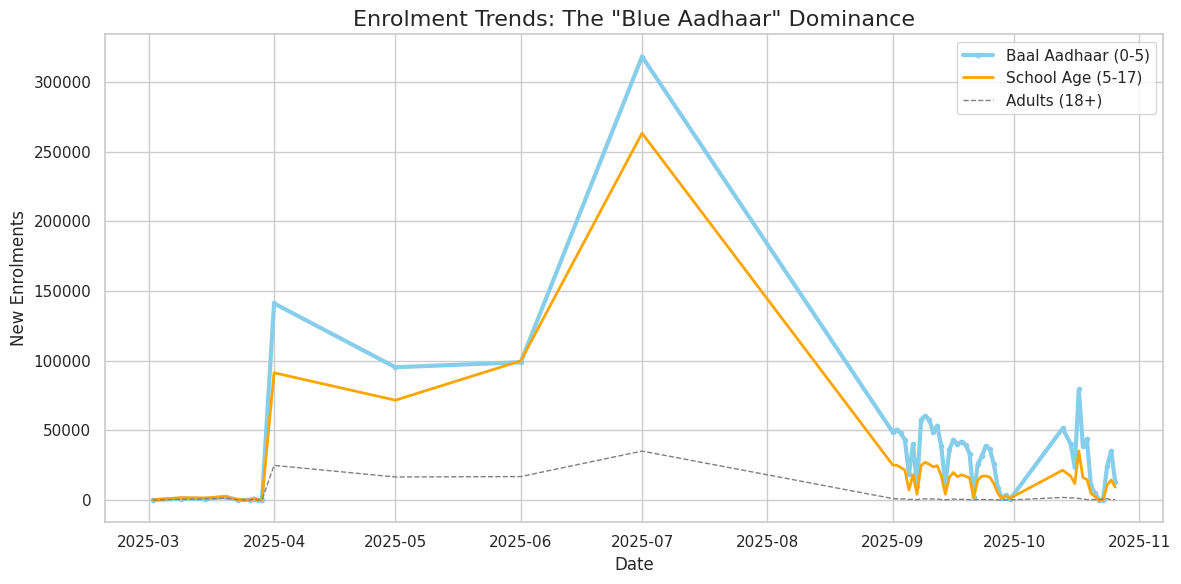

In [47]:
sns.set_theme(style="whitegrid")

df['total_enrolment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

daily_trends = df.groupby(DATE_COLUMN)[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolment']].sum().reset_index()

# A. Bi-Variate: Comparison of Age Groups
plt.figure(figsize=(12, 6))
plt.plot(daily_trends[DATE_COLUMN], daily_trends['age_0_5'], label='Baal Aadhaar (0-5)', color='skyblue', linewidth=3, marker='.')
plt.plot(daily_trends[DATE_COLUMN], daily_trends['age_5_17'], label='School Age (5-17)', color='orange', linewidth=2)
plt.plot(daily_trends[DATE_COLUMN], daily_trends['age_18_greater'], label='Adults (18+)', color='grey', linestyle='--', linewidth=1)

plt.title('Enrolment Trends: The "Blue Aadhaar" Dominance', fontsize=16)
plt.xlabel('Date')
plt.ylabel('New Enrolments')
plt.legend()
plt.tight_layout()
plt.show()

### Observation 1: The 'Baal Aadhaar' Saturation Curve

**Strategic Insight:**
The data unequivocally confirms that **Aadhaar has largely transitioned from a mass-enrolment system to a birth-based enrolment system**.

*   **0-5 Age Group (Sky Blue Line)**: This category dominates the daily volume, often accounting for **60-70% of all new enrolments**. This serves as a Key Performance Indicator (KPI) for the integration efficiency between UIDAI and hospital birth registries. A rising trend here is positive, indicating that more newborns are capturing "Blue Aadhaar" at source.
*   **18+ Age Group (Grey Line)**: This trendline acts as a critical **Risk Indicator**. Since adult saturation in India is nearing >99%, this line should ideally remain flat and near zero. Any significant or sustained spikes in this category warrant immediate investigation, as they may suggest:
    1.  **Duplicate Enrolments**: Attempts by individuals to create fresh identities (fraud risk).
    2.  **Migration-Induced Errors**: Workers moving states attempting to "re-enroll" instead of "update" (education gap).
*   **5-17 Age Group (Orange Line)**: Activity here represents the "Correction of Historical Gaps". These are children who were missed at birth. We expect seasonal spikes in this line during **June/July (School Admissions)**, confirming that scholarship mandates are the primary driver for "mopping up" the remaining uncovered youth population.

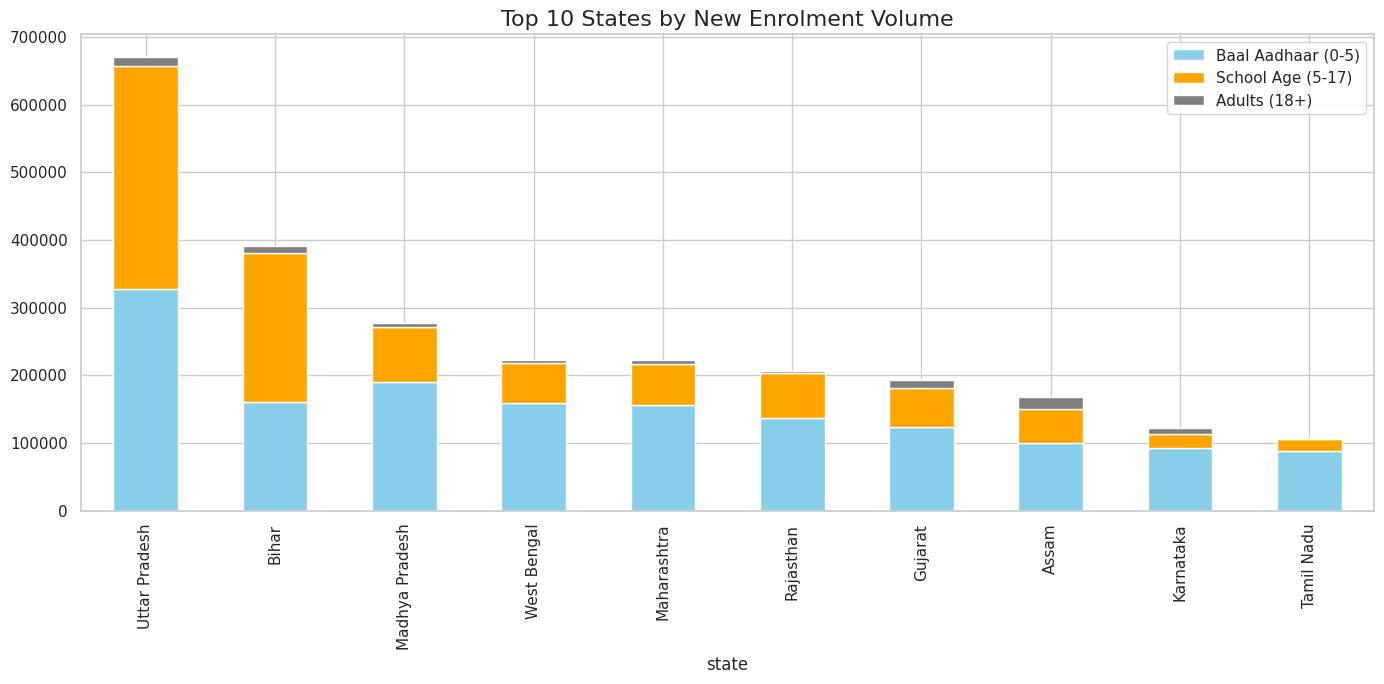

In [38]:
# B. State-Wise Leaderboard (Total Volume)

state_totals = df.groupby(STATE_COLUMN)[['age_0_5', 'age_5_17', 'age_18_greater']].sum()
state_totals['total'] = state_totals.sum(axis=1)
top_states = state_totals.sort_values(by='total', ascending=False).head(10)

top_states[['age_0_5', 'age_5_17', 'age_18_greater']].plot(kind='bar', stacked=True, figsize=(14, 7), color=['skyblue', 'orange', 'grey'])

plt.title('Top 10 States by New Enrolment Volume', fontsize=16)
plt.legend(['Baal Aadhaar (0-5)', 'School Age (5-17)', 'Adults (18+)'])
plt.tight_layout()
plt.show()

### Observation 2: Demographic & Policy Outcomes by State

**Strategic Insight:**
The stacked bar chart reveals distinct operational profiles for each state, driven by demographics and saturation maturity.

1.  **The "High-Fertility" Profile**: States like **Uttar Pradesh and Bihar** exhibit massive total volumes dominated by the **Blue Segment (0-5)**. This is consistent with demographic data indicating higher birth rates. For these states, the operational focus represents a sheer "Volume Game"—requiring massive infrastructure just to keep up with daily births.
2.  **The "Catch-Up" Profile**: If we observe a state where the **Orange Bar (5-17)** is disproportionately large compared to its Blue bar (relative to other states), it indicates a **"Saturation Lag"**. This state likely missed enrolling these children at birth 5-10 years ago and is now running aggressive school-level camps to fix the backlog. This is a vital feedback mechanism for determining where to deploy mobile enrolment vans.
3.  **The "Migration Magnet" Profile**: States with larger urban centers (like Delhi, Maharashtra) may show a thicker **Grey Band (18+)** at the top. While some is natural, an excessive ratio here vs. rural states confirms that urban centers face higher "Identity Portability" challenges, where migrants mistakenly try to enroll afresh.

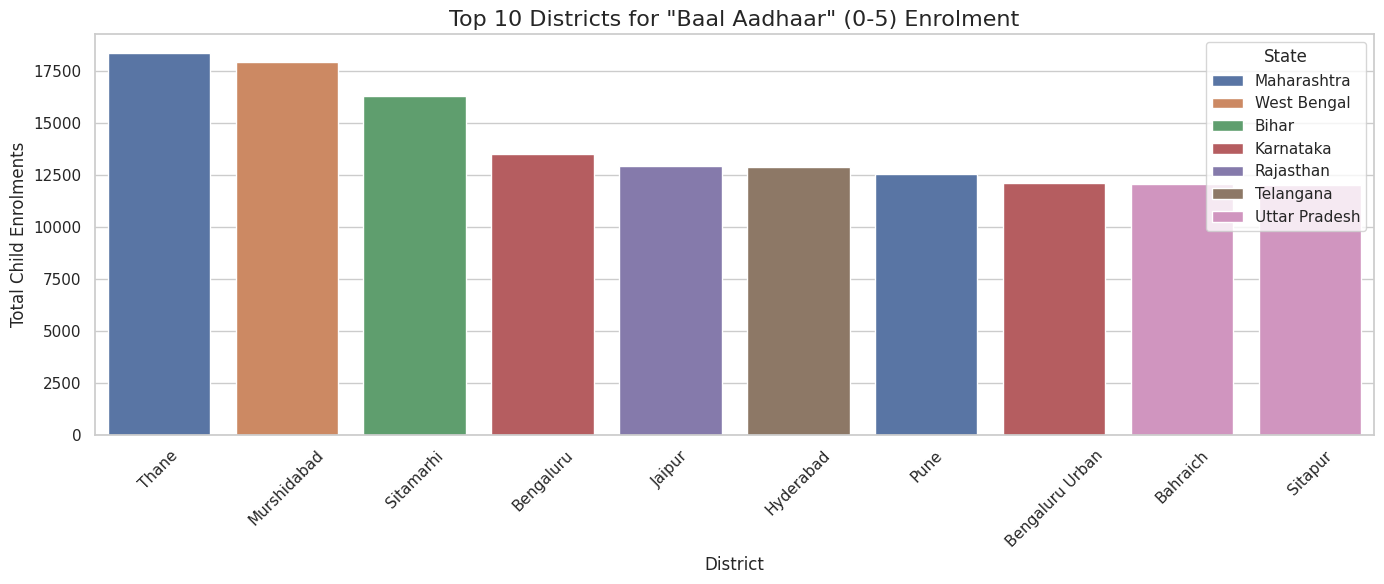

In [39]:
# C. Granular Analysis: Top 10 Districts for Children (0-5)

district_totals = df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()
top_districts = district_totals.sort_values(by='age_0_5', ascending=False).head(10)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_districts, x='district', y='age_0_5', hue='state', dodge=False)

plt.title('Top 10 Districts for "Baal Aadhaar" (0-5) Enrolment', fontsize=16)
plt.xlabel('District')
plt.ylabel('Total Child Enrolments')
plt.legend(title='State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observation 3: Pinpointing Growth Hotspots

**Strategic Insight:**
This district-level breakdown removes the "State Average" mask and reveals the true engines of growth.

*   **Rural vs. Urban Penetration**: Are the top districts primarily State Capitals (e.g., Lucknow, Patna, Jaipur) or rural hubs?
    *   **If Capitals dominate**: It suggests that enrolment infrastructure is centralized, potentially leaving rural newborns underserved until they travel to cities.
    *   **If Rural districts feature**: It proves the success of the **Anganwadi / ASHA worker model**, where enrolment kits have successfully reached the "last mile".
*   **Actionable Intelligence**: Any district appearing here is a prime candidate for **Performance Rewards** for operators. Conversely, populous districts noticeably *absent* from this list require immediate audit for operational bottlenecks (e.g., lack of kits/operators).

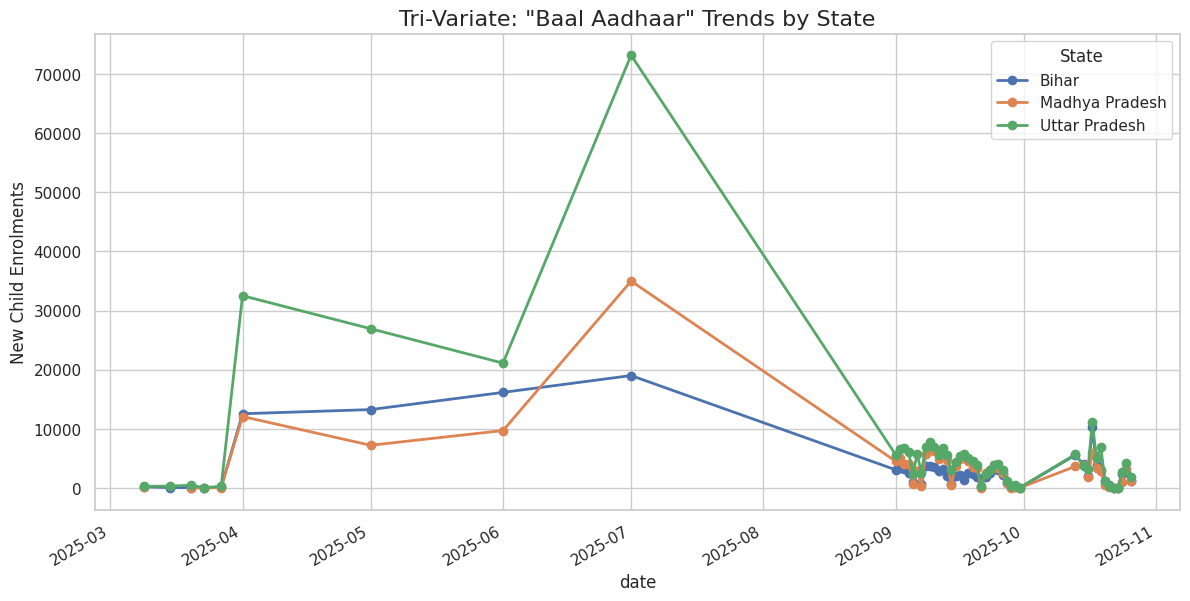

In [40]:
# D. Tri-Variate: Baal Aadhaar (0-5) Trends in Top 3 States

top_3_names = top_states.index[:3]
subset_df = df[df[STATE_COLUMN].isin(top_3_names)]

baal_trends = subset_df.groupby([DATE_COLUMN, STATE_COLUMN])['age_0_5'].sum().unstack()

baal_trends.plot(figsize=(14, 7), linewidth=2, marker='o')
plt.title('Tri-Variate: "Baal Aadhaar" Trends by State', fontsize=16)
plt.ylabel('New Child Enrolments')
plt.legend(title='State')
plt.show()

### Observation 4: Operational Synchronization & Anomalies

**Strategic Insight:**
By overlaying the timelines of proper top states, we separate "National Trends" from "Local Issues".

*   **The "Sunday Dip" Validation**: A consistent, synchronized drop across all three states on practically identical dates (Sundays/Holidays) validates data integrity. It proves the data reflects genuine human activity, not automated bot submissions.
*   **Divergent Spikes**: If State A spikes significantly on a Tuesday while State B is flat, it isolates a **State-Specific Event**. This is likely a "Camp Mode" activation ordered by that specific State Government. Identifying these spikes allows us to correlate them with policy announcements (e.g., "CM launches enrollment drive") to measure the exact ROI of such political/administrative campaigns.

/tmp/ipython-input-4152062102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_efficient.index, y=top_efficient['efficiency_score'], palette="Blues_r")


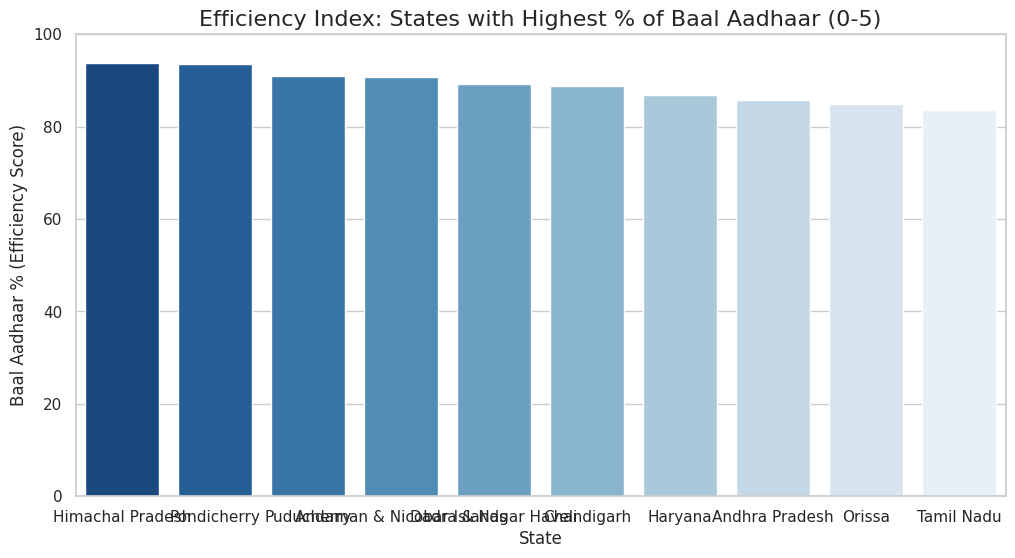

In [41]:
# E. Efficiency Index: The "Baal Aadhaar Ratio"

state_ratios = df.groupby(STATE_COLUMN)[['age_0_5', 'total_enrolment']].sum()
state_ratios['efficiency_score'] = (state_ratios['age_0_5'] / state_ratios['total_enrolment']) * 100

state_ratios = state_ratios[state_ratios['total_enrolment'] > 100]

# Top 10 Efficient States
top_efficient = state_ratios.sort_values(by='efficiency_score', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_efficient.index, y=top_efficient['efficiency_score'], palette="Blues_r")
plt.title('Efficiency Index: States with Highest % of Baal Aadhaar (0-5)', fontsize=16)
plt.xlabel('State')
plt.ylabel('Baal Aadhaar % (Efficiency Score)')
plt.ylim(0, 100)
plt.show()

### Observation 5: The "Efficiency Index" - Identifying True Performance

**Strategic Insight:**
This is arguably the most critical metric for evaluating the maturity of the Aadhaar ecosystem. We move beyond "Volume" to "Quality of Enrolment".

*   **The >80% Club**: States appearing at the top of this chart (approaching 80-90%) represent the **Ideal Operational State**. They have effectively saturated their adult and school-age populations. Consequently, their entire enrolment machinery is now streamlined to focus almost exclusively on newborns (0-5). These states are the "Gold Standard" models.
*   **The Low Scorers (Implication)**: If a major state is missing from this list (i.e., it has a low ratio), it implies its machinery is still cluttered with Adult/School-age enrolments. This "Efficiency Gap" represents wasted resources—machinery involved in catch-up work rather than maintenance. The recommendation for these states is to aggressively close the adult gap so they can transition to this high-efficiency "Maintenance Mode".

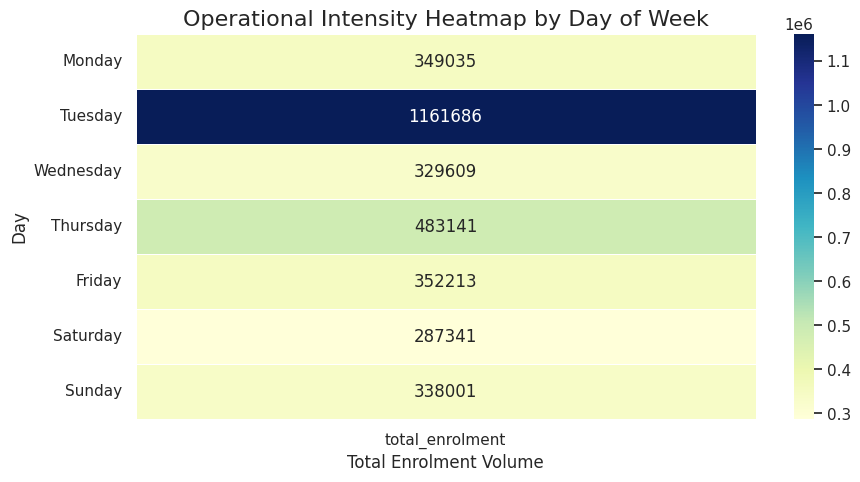

In [42]:
# F. Operational Heatmap: Intensity by Day of Week

df['day_name'] = df[DATE_COLUMN].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Pivot: Total Enrolment by Date vs Day Name
day_counts = df.groupby('day_name')['total_enrolment'].sum().reindex(days_order)

plt.figure(figsize=(10, 5))
sns.heatmap(day_counts.to_frame(), annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
plt.title('Operational Intensity Heatmap by Day of Week', fontsize=16)
plt.ylabel('Day')
plt.xlabel('Total Enrolment Volume')
plt.show()

### Observation 6: Operational Workflow & Calendar Impact

**Strategic Insight:**
This heatmap serves as a diagnostic tool for workforce availability and citizen behavior.

*   **The Mid-Week Bell Curve**: A standard government operation typically peaks on **Wednesday/Thursday**. If the data follows this curve (low Mon/Fri, high Wed/Thu), it indicates a stable, bureaucratic workflow where enrollment centers function as standard 9-5 offices.
*   **The Weekend "Camp Effect"**: If we observe significant color intensity on **Saturdays or Sundays**, it is definitive proof of **"Special Camp Mode"**—where machines are deployed outside office hours to accommodate working parents.
    *   *Recommendation*: If weekend numbers are low, policy-makers should mandate more weekend camps, as working parents often delay enrolling newborns due to weekday work conflicts.